This script analyzes and compares different mathematical approximations for gyroaveraging operators used in plasma physics, specifically in the context of gyrokinetics. The primary goal is to visualize the accuracy of Padé approximants against their "exact" counterparts, which involve exponential and Bessel functions.

The script defines several key functions:

- **Exact Gyroaveraging Operators**:
    - The $\Gamma_1^s$ operator is defined as:
        $$ \Gamma_{1,ex}^s(k_\perp) = e^{-\frac{1}{2}(k_\perp \rho_s)^2} $$
        This corresponds to `gamma1_ex(kperp, s)`.
    - The $\Gamma_0^s$ operator is defined using the modified Bessel function of the first kind, $I_0$:
        $$ \Gamma_{0,ex}^s(k_\perp) = \Gamma_{1,ex}^s(k_\perp) \cdot I_0(-(k_\perp \rho_s)^2) $$
        This corresponds to `gamma0_ex(kperp, s)`.

- **Padé Approximants for Gyroaveraging Operators**:
    - The Padé approximant for $\Gamma_1^s$ is:
        $$ \Gamma_{1,Padé}^s(k_\perp) = \frac{1}{1 + \frac{1}{2}(k_\perp \rho_s)^2} $$
        This corresponds to `gamma1_pade(kperp, s)`.
    - The Padé approximant for $\Gamma_0^s$ is:
        $$ \Gamma_{0,Padé}^s(k_\perp) = \frac{1}{1 + (k_\perp \rho_s)^2} $$
        This corresponds to `gamma0_pade(kperp, s)`.

- **Polarization Operator**:
    - A function to compute the polarization density operator is defined as a sum over all particle species $s$:
        $$ \text{pol\_op}(k_\perp) = \sum_s \frac{n_{0s} q_s^2}{T_{0s}} (1 - \Gamma_0^s(k_\perp)) $$
        This corresponds to `polarization_op(kperp, species_list, G0func)`, where `G0func` can be either the exact or the Padé version of $\Gamma_0^s$.

The script then initializes physical constants and defines several plasma species (electrons, H+, D+, and two charge states of Tungsten) with specific physical properties using the `pygkyl` library. It sets up a computational grid and a corresponding wavenumber grid $k_\perp$.

Finally, it generates a set of four plots:
1.  Compares the exact $\Gamma_0^s$ and its Padé approximant for all defined species.
2.  Compares the exact $\Gamma_1^s$ and its Padé approximant for all defined species.
3.  Plots the total polarization density operator using both the exact and Padé forms of $\Gamma_0^s$.

In [57]:
import pygkyl
import numpy as np
import matplotlib.pyplot as plt
import src.flr_operators_inc as flr

# Define the different species
elc     = pygkyl.Species(name = 'e-',   q = -1.0*flr.eV, m = 5.4858e-4*flr.amu, T0 = 100*flr.eV, n0 = 1e19)
Dplus   = pygkyl.Species(name = 'D+',   q = 1.0*flr.eV,  m = 2.014*flr.amu,     T0 = 100*flr.eV, n0 = 1e19)
Tplus   = pygkyl.Species(name = 'T+',   q = 1.0*flr.eV,  m = 3.016*flr.amu,     T0 = 100*flr.eV, n0 = 1e19)
W10plus = pygkyl.Species(name = 'W10+', q = 10*flr.eV,   m = 183.84*flr.amu,    T0 = 100*flr.eV, n0 = 1e15)
W45plus = pygkyl.Species(name = 'W45+', q = 45*flr.eV,   m = 183.84*flr.amu,    T0 = 100*flr.eV, n0 = 1e15)

# ctx = flr.Context(species_list=[elc, Dplus, Tplus, W10plus, W45plus])
ctx = flr.Context(species_list=[elc, Dplus, W45plus])

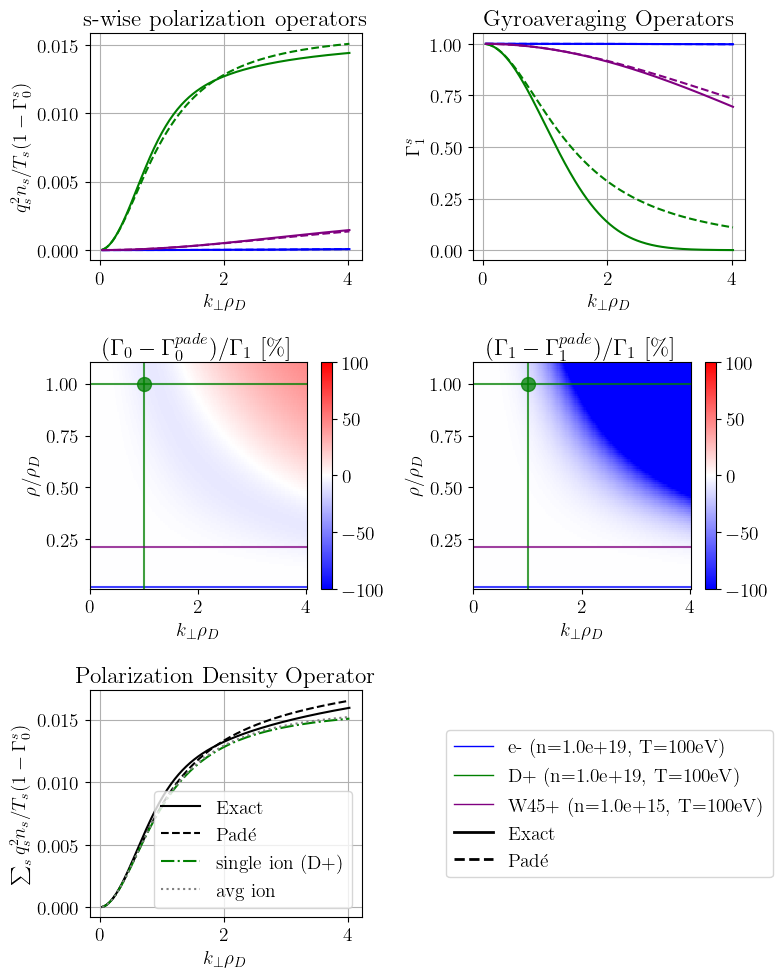

In [58]:
rhogrid = ctx.rhogrid
kgrid = ctx.kgrid
KK, RR = np.meshgrid(kgrid, rhogrid, indexing='ij')

fig, ax_grid = plt.subplots(3,2, figsize=(8,10))
ax = ax_grid.flatten()

x = kgrid * Dplus.rho

## First axis for gamma0
for i, s in enumerate(ctx.species):
    color = s.color
    # ax[0].plot(x, flr.gamma0_ex(kgrid, s.rho), color=color)
    # ax[0].plot(x, flr.gamma0_pade(kgrid, s.rho), color=color, linestyle='--')
    ax[0].plot(x, flr.pol_species(kgrid, s, ctx.Bref, G0func=flr.gamma0_ex), color=color)
    ax[0].plot(x, flr.pol_species(kgrid, s, ctx.Bref, G0func=flr.gamma0_pade), color=color, linestyle='--')

ax[0].set_xlabel(r'$k_\perp \rho_D$')
# ax[0].set_ylabel(r'$\Gamma_0^s$')
ax[0].set_ylabel(r'$q_s^2 n_s / T_s (1 - \Gamma_0^s)$')
ax[0].set_title(r's-wise polarization operators')
ax[0].grid()

## Second axis Gamma1
for i, s in enumerate(ctx.species):
    color = s.color
    ax[1].plot(x, flr.gamma1_ex(kgrid, s.rho), color=color)
    ax[1].plot(x, flr.gamma1_pade(kgrid, s.rho), color=color, linestyle='--')

ax[1].set_xlabel(r'$k_\perp \rho_D$')
ax[1].set_ylabel(r'$\Gamma_1^s$')
ax[1].set_title(r'Gyroaveraging Operators')
ax[1].grid()  

## Third axis
idx = 2
# Plot the error between of Gamma0
Zex = flr.gamma0_ex(KK, RR)
Zpade = flr.gamma0_pade(KK, RR)
Zerr = (Zex - Zpade)/Zex*100
im = ax[idx].pcolormesh(KK*Dplus.rho, RR/Dplus.rho, Zerr, shading='auto', vmin=-100, vmax=100)
im.cmap = 'bwr'
cbar = fig.colorbar(im, ax=ax[idx])
ax[idx].set_xlabel(r'$k_\perp \rho_D$')
ax[idx].set_ylabel(r'$\rho/\rho_D$')
ax[idx].set_title(r'$(\Gamma_0 - \Gamma_0^{pade})/\Gamma_1$ [\%]')
# plot a line at rho for each species
for i, s in enumerate(ctx.species):
    color = s.color
    ax[idx].axhline(y=s.rho/Dplus.rho, linestyle='-', color=color, alpha=0.75)
    ax[idx].axvline(x=Dplus.rho/s.rho, linestyle='-', color=color, alpha=0.75)
    ax[idx].scatter([Dplus.rho/s.rho], [s.rho/Dplus.rho], color=color, marker='o', s=100, alpha=0.75)
ax[idx].set_xlim([0, ctx.kmax*Dplus.rho])


## Fourth axis
idx = 3
# Plot the error between of Gamma1
Zex = flr.gamma1_ex(KK, RR)
Zpade = flr.gamma1_pade(KK, RR)
Zerr = (Zex - Zpade)/Zex*100
im = ax[idx].pcolormesh(KK*Dplus.rho, RR/Dplus.rho, Zerr, shading='auto', vmin=-100.0, vmax=100.0)
im.cmap = 'bwr'
cbar = fig.colorbar(im, ax=ax[idx])
ax[idx].set_xlabel(r'$k_\perp \rho_D$')
ax[idx].set_ylabel(r'$\rho/\rho_D$')
ax[idx].set_title(r'$(\Gamma_1 - \Gamma_1^{pade})/\Gamma_1$ [\%]')
# plot a line at rho for each species
for i, s in enumerate(ctx.species):
    color = s.color
    ax[idx].axhline(y=s.rho/Dplus.rho, linestyle='-', color=color, alpha=0.75)
    ax[idx].axvline(x=Dplus.rho/s.rho, linestyle='-', color=color, alpha=0.75)
    ax[idx].scatter([Dplus.rho/s.rho], [s.rho/Dplus.rho], color=color, marker='o', s=100, alpha=0.75)
ax[idx].set_xlim([0, ctx.kmax*Dplus.rho])

## Fifth axis
idx = 4
pol_op_ex = ctx.polarization_op(kgrid, flr.gamma0_ex)
pol_op_pade = ctx.polarization_op(kgrid, flr.gamma0_pade)
single_ion = Dplus
pol_op_single_ion = ctx.polarization_op_single_ion(kgrid, ctx.ntot_ion, single_ion.q, single_ion.m, single_ion.T0, flr.gamma0_pade)
pol_op_avg_ion = ctx.polarization_op_single_ion(kgrid, ctx.ntot_ion, ctx.qavg_ion, ctx.mavg_ion, ctx.Tavg_ion,flr.gamma0_pade)
ax[idx].plot(x, pol_op_ex, color='k', label='Exact')
ax[idx].plot(x, pol_op_pade, color='k', linestyle='--', label='Padé')
ax[idx].plot(x, pol_op_single_ion, color=single_ion.color, linestyle='-.', label='single ion (%s)'%single_ion.name)
ax[idx].plot(x, pol_op_avg_ion, color='gray', linestyle=':', label='avg ion')
ax[idx].set_xlabel(r'$k_\perp \rho_D$')
ax[idx].set_ylabel(r'$\sum_s q_s^2 n_s / T_s (1 - \Gamma^s_0)$')
ax[idx].set_title(r'Polarization Density Operator')
ax[idx].grid()
ax[idx].legend()

## Sixth axis
idx = 5

from matplotlib.lines import Line2D
legend_elements_species = [Line2D([0], [0], color=s.color, lw=1, label=f'{s.name} (n={s.n0:.1e}, T={s.T0/flr.eV:.0f}eV)') for i, s in enumerate(ctx.species)]
legend_elements_style = [Line2D([0], [0], color='k', linestyle='-', lw=2, label='Exact'),
                         Line2D([0], [0], color='k', linestyle='--', lw=2, label='Padé')]
custom_legend = legend_elements_species + legend_elements_style
ax[idx].axis('off')
ax[idx].legend(handles=custom_legend, loc='center', ncol=1)


plt.tight_layout()

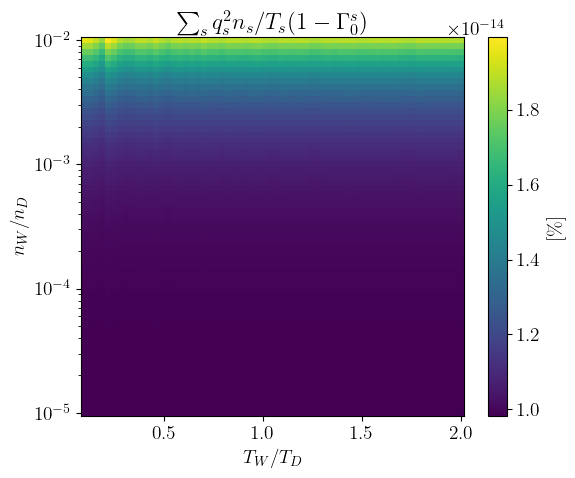

In [65]:
# Define the different species
Dplus   = pygkyl.Species(name = 'D+',   q = 1.0*flr.eV, m = 2.014*flr.amu, T0 = 100*flr.eV, n0 = 1e19)
Wnplus = pygkyl.Species(name = 'W45+', q = 45*flr.eV, m = 183.84*flr.amu, T0 = 100*flr.eV, n0 = 1e16)
Wnplus.color = 'purple'

Bref = 2.0
ctx = flr.Context(species_list=[Dplus, Wnplus], Bref=2.0)

kperp = ctx.species_get('D+', 'rho') * 1.5

# Scan over the temperature and density ratios
Tratios = np.linspace(0.1, 2.0, 64)
nratios = np.logspace(-5, -2, 64)
tt, nn = np.meshgrid(Tratios, nratios, indexing='ij')
TD = np.ones_like(tt) * ctx.species_get('D+', 'T0')
nD = np.ones_like(nn) * ctx.species_get('D+', 'n0')
TW = tt * ctx.species_get('D+', 'T0')
nW = nn * ctx.species_get('D+', 'n0')

pol_op_ex = flr.pol_op(kperp, n_list=[nD, nW], q_list=[Dplus.q, Wnplus.q], m_list=[Dplus.m, Wnplus.m], T_list=[TD, TW], Bref=Bref, G0func=flr.gamma0_ex)
pol_op_pade = flr.pol_op(kperp, n_list=[nD, nW], q_list=[Dplus.q, Wnplus.q], m_list=[Dplus.m, Wnplus.m], T_list=[TD, TW], Bref=Bref, G0func=flr.gamma0_pade)
pol_op_single_ion = flr.pol_op(kperp, n_list=[nD + nW], q_list=[Dplus.q], m_list=[Dplus.m], T_list=[Dplus.T0], Bref=Bref, G0func=flr.gamma0_pade)
pol_op_avg_ion = flr.pol_op(kperp, n_list=[nD + nW], q_list=[Dplus.q], m_list=[Dplus.m], T_list=[(nD*TD + nW*TW)/(nD + nW)], Bref=Bref, G0func=flr.gamma0_pade)

fig2, ax2 = plt.subplots(1,1, figsize=(6,5))

Z = pol_op_ex
im = ax2.pcolormesh(tt, nn, Z, shading='auto')
im.cmap = 'viridis'
ax2.set_title(r'$\sum_s q_s^2 n_s / T_s (1 - \Gamma_0^s)$')

# Z_err = (pol_op_ex - pol_op_single_ion)/pol_op_ex*100
# im = ax2.pcolormesh(tt, nn, Z_err, shading='auto', vmin=-50, vmax=50)
# im.cmap = 'bwr'
# ax2.set_title(r'$(\sum_s (1 - \Gamma_0^s) - \sum_s (1 - \Gamma_0^{s,pade}))/\sum_s (1 - \Gamma_0^s)$ [\%]')

cbar = fig2.colorbar(im, ax=ax2)
cbar.set_label(r'[\%]')
ax2.set_xlabel(r'$T_W/T_D$')
ax2.set_ylabel(r'$n_W/n_D$')
ax2.set_xscale('linear')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

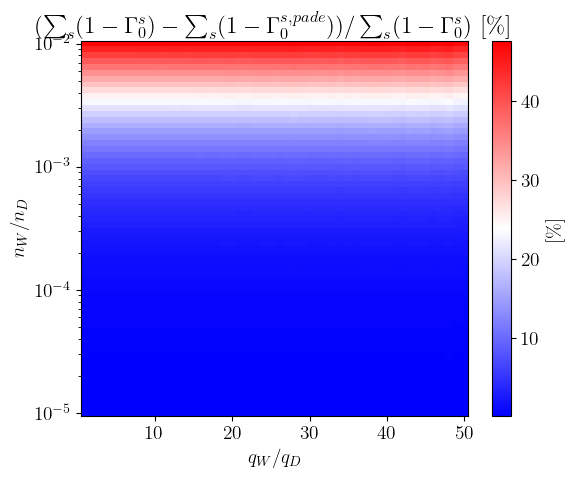

In [64]:
# Define the different species
Dplus   = pygkyl.Species(name = 'D+',   q = 1.0*flr.eV, m = 2.014*flr.amu, T0 = 100*flr.eV, n0 = 1e19)
Znplus = pygkyl.Species(name = 'W45+', q = 45*flr.eV, m = 183.84*flr.amu, T0 = 100*flr.eV, n0 = 1e16)
Wnplus.color = 'purple'

Bref = 2.0
ctx = flr.Context(species_list=[Dplus, Wnplus], Bref=2.0)

kperp = ctx.species_get('D+', 'rho') * 1.5

# Scan over the temperature and density ratios
qratios = np.linspace(1, 50, 50)
nratios = np.logspace(-5, -2, 64)
qq, nn = np.meshgrid(qratios, nratios, indexing='ij')
qD = np.ones_like(qq) * ctx.species_get('D+', 'q')
nD = np.ones_like(nn) * ctx.species_get('D+', 'n0')
qW = qq * ctx.species_get('D+', 'q')
nW = nn * ctx.species_get('D+', 'n0')

pol_op_ex = flr.pol_op(kperp, n_list=[nD, nW], q_list=[qD, qW], m_list=[Dplus.m, Wnplus.m], T_list=[Dplus.T0, W45plus.T0], Bref=Bref, G0func=flr.gamma0_ex)
pol_op_pade = flr.pol_op(kperp, n_list=[nD, nW], q_list=[qD, qW], m_list=[Dplus.m, Wnplus.m], T_list=[Dplus.T0, W45plus.T0], Bref=Bref, G0func=flr.gamma0_pade)
pol_op_single_ion = flr.pol_op(kperp, n_list=[nD + nW], q_list=[Dplus.q], m_list=[Dplus.m], T_list=[Dplus.T0], Bref=Bref, G0func=flr.gamma0_pade)
qavg = (nD*qD + nW*qW)/(nD + nW)
Tavg = (nD*Dplus.T0 + nW*Wnplus.T0)/(nD + nW)
pol_op_avg_ion = flr.pol_op(kperp, n_list=[nD + nW], q_list=[qavg], m_list=[Dplus.m], T_list=[Tavg], Bref=Bref, G0func=flr.gamma0_pade)

# print(pol_op_ex.shape)
Z_err = (pol_op_ex - pol_op_single_ion)/pol_op_ex*100

fig2, ax2 = plt.subplots(1,1, figsize=(6,5))
im = ax2.pcolormesh(qq, nn, Z_err, shading='auto')
im.cmap = 'bwr'
cbar = fig2.colorbar(im, ax=ax2)
cbar.set_label(r'[\%]')
ax2.set_xlabel(r'$q_W/q_D$')
ax2.set_ylabel(r'$n_W/n_D$')
ax2.set_xscale('linear')
ax2.set_yscale('log')
ax2.set_title(r'$(\sum_s (1 - \Gamma_0^s) - \sum_s (1 - \Gamma_0^{s,pade}))/\sum_s (1 - \Gamma_0^s)$ [\%]')
plt.tight_layout()
plt.show()